# Importing

In [1292]:
import numpy as np
from scipy.linalg import solve as solve_system
import pickle
import time
import os
from copy import copy

import matplotlib.pyplot as plt
%matplotlib widget

# Getting Data:

In [1293]:
CWD = os.getcwd()

# 1D Data:
# with open(f'{CWD}/FMs.pck', 'rb') as f:
#     FM = pickle.load(f)
# with open(f'{CWD}/genomes.pck', 'rb') as f:
#     G  = pickle.load(f)

# 2D Data:
with open(f'{CWD}/FM2d_old.pck', 'rb') as f:
    FM = pickle.load(f)
with open(f'{CWD}/genomes2d_old.pck', 'rb') as f:
    G  = pickle.load(f)

# # 3D Data:
# with open(f'{CWD}/FM2d.pck', 'rb') as f:
#     FM = pickle.load(f)
# with open(f'{CWD}/genomes2d.pck', 'rb') as f:
#     G  = pickle.load(f)

# print(np.array(G).shape)

num_sets = len(G)
FM_size = FM[0].shape[0]

FM = np.array(FM)
# G  = np.array(G).reshape((num_sets,FM_size,-1))
Go = copy(G)
num_genomes = np.array(G).shape[1] // FM_size
G = np.zeros((num_sets,FM_size,num_genomes))
for i in range(num_sets):
    for j in range(FM_size):
        for k in range(num_genomes):
            G[i,j,k] = Go[i][j+k*FM_size]

In [1294]:
print(FM.shape)
print(G.shape)

# a = 1
# b = 0
# s = 0.001

# FM = a*np.repeat(G[:,:,[0]], 121, axis=2)+b
# FM = FM+s*np.random.randn(*FM.shape)

(48, 100, 100)
(48, 100, 2)


# Source/Destination Relationship

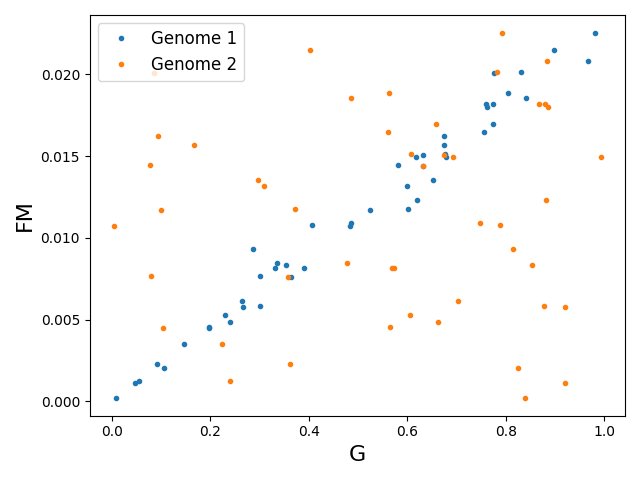

In [1295]:
I1,J1 = (6,4)
I2,J2 = (5,4)

cells_per_side = int(np.sqrt(G.shape[1]))

idx1 = I1*cells_per_side+J1
idx2 = I2*cells_per_side+J2

plt.figure(1)
plt.clf()
for k in range(num_genomes):
    G0 = G[:,:,[k]]
    X = np.repeat(G0, 121, axis=2)
    # X = X.transpose((0,2,1))
    X = X[:,idx2,idx1]
    Y = FM[:,idx2,idx1]
    plt.plot(X,Y,'.', label=f'Genome {k+1}')
plt.xlabel('G', fontsize=16)
plt.ylabel('FM', fontsize=16)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [1296]:
# raise RuntimeError()

# Making Parents and Children

In [1297]:
IJ = (9,8) # Spatial Cell Index

n  = 12  # Number of nearest neighbors
Nc = 25 # Number of children

# Taking a subset of the data:
Case = 'UM'
# Cases = {'UPM':[0,1,2],'UP':[0,1],'UM':[0,2],'PM':[1,2],'U':[0],'P':[1],'M':[2]}
Cases = {'UM':[0,1],'U':[0],'M':[1]}
G  = G[:,:,Cases[Case]]

permutation = np.random.permutation(G.shape[0])

Gc  =  G[permutation[:Nc],:,:]
FMc = FM[permutation[:Nc],:,:]
Gs  =  G[permutation[Nc:],:,:]
FMs = FM[permutation[Nc:],:,:]

# print(G.shape)
# print(FM.shape)

# Functions

In [1298]:
def find_nearest_neighbors(genome_children, genomes, FMs, n:int=3):
    """
    Finds the nearest genomes and respective FM matrices.

    * INPUTS:
    genome_children : children genome array
    genomes         : evaluated genome array
    FMs             : evaluated fission matrix Array
    n               : number of nearest neighbors to find

    * RETURNS:
    genome_neighbors : n nearest neighbors of the child genome array
    FM_neighbors     : n nearest neighbors of the parent genome array

    * NOTES:
    The dimensions of the input and output variables are as follows:

    genome_children index 0 : child genome reference index
    genome_children index 1 : spatial cell index
    genome_children index 2 : genome in spatial cell (i.e. UO2 density=0, Pu density=1)

    genomes index 0 : evaluated genome reference index
    genomes index 1 : spatial cell index
    genomes index 2 : genome in spatial cell (i.e. UO2 density=0, Pu density=1)

    FMs index 0 : evaluated fission matrix reference index
    FMs index 1 : destination spatial cell index
    FMs index 2 : source spatial cell index

    genome_neighbors index 0 : child genome reference index
    genome_neighbors index 1 : spatial cell index
    genome_neighbors index 2 : i-th nearest neighbor
    genome_neighbors index 3 : genome in spatial cell (i.e. UO2 density=0, Pu density=1)

    FM_neighbors index 0 : child genome reference index
    FM_neighbors index 1 : destination spatial cell index
    FM_neighbors index 2 : source spatial cell index
    FM_neighbors index 3 : i-th nearest neighbor
    """

    def find_nearest_individual(genome_child):
        indices = np.random.permutation(genomes.shape[0])[:n]
        # indices = np.argsort([np.linalg.norm(genome-genome_child) for genome in genomes])[:n]
        genome_neighbors  =  genomes[indices,:,:]
        FM_neighbors = FMs[indices,:,:]
        return genome_neighbors, FM_neighbors

    neighbor_set = [find_nearest_individual(genome_child) for genome_child in genome_children]
    genome_neighbors, FM_neighbors = tuple([list(el) for el in zip(*neighbor_set)])
    genome_neighbors = np.array(genome_neighbors).transpose((0,2,1,3))
    FM_neighbors = np.array(FM_neighbors).transpose((0,2,3,1))
    return genome_neighbors, FM_neighbors


def regression(Xn,Yn,Xc):
    N = len(Xn.shape)
    XnT = Xn.transpose((*np.arange(N-2), N-1, N-2))
    S = XnT @ Xn
    Yc = Xc @ np.linalg.solve(S, XnT @ Yn) # NOTE: Could be solved faster if we use special inversion for symmetric, positive, definite matrices
    return Yc

def EstimateFM(Gc, Gn, FMn):
    """
    Estimates the FM matrix with a linear regression with the nearest genomes.

    * INPUTS:
    Gc  : child genome array
    Gn  : nearest neighbor genome array
    FMn : nearest neighbor Fission Matrix array

    * RETURNS:
    FMc : child Fission Matrix array
    
    * NOTES:
    The linear regression is highly parallelizable, so we can perform all FM
    estimates for all children in parallel. The dimensions of the input and
    output variables are as follows:

    Gn index 0 : child number that needs a FM estimate
    Gn index 1 : spatial cell index
    Gn index 2 : i-th nearest neighbor
    Gn index 3 : genome in spatial cell (i.e. UO2 density=0, Pu density=1)

    FMn index 0 : child number that needs a FM estimate
    FMn index 1 : destination spatial cell index
    FMn index 2 : source spatial cell index
    FMn index 3 : i-th nearest neighbor 

    Gc index 0 : child number that needs a FM estimate
    Gc index 1 : spatial cell index
    Gc index 2 : genome in spatial cell (i.e. UO2 density=0, Pu density=1)

    FMc index 0 : child number that needs a FM estimate
    FMc index 1 : destination spatial cell index
    FMc index 2 : source spatial cell index
    """
    # t1 = time.time()

    n = Gn.shape[2] # Number of nearest neighbors
    k = Gn.shape[3] # Number of genomes per spatial cell
    if n < k + 1: # Just take the nearest FM as a guess
        raise ValueError(f'WARNING: you need {k+1} nearest neighbors to perform a regression over {k} genomes per spatial cell.')

    # Neighbor Genome Preparation:
    Xn  = np.concatenate((Gn, np.ones((*Gn.shape[:-1],1))), axis=3)
    Xn  = Xn[:,:,:,:,np.newaxis].transpose((0,1,4,2,3))
    Xn  = np.repeat(Xn, FMn.shape[2], axis=2)

    # t2 = time.time()
    # print('1 -> 2', t2-t1)

    # Child Genome Preparation:
    Xc = Gc[:,:,:,np.newaxis,np.newaxis].transpose((0,1,3,4,2))
    Xc = np.concatenate((Xc, np.ones((*Xc.shape[:-1],1))), axis=4)
    Xc = np.repeat(Xc, FMn.shape[2], axis=2)

    # t3 = time.time()
    # print('2 -> 3', t3-t2)

    # Neigbor FM Preparation:
    Yn = FMn[:,:,:,:,np.newaxis]

    # t4 = time.time()
    # print('3 -> 4', t4-t3)

    # print('=============')
    # print('Xn  : ', Xn.shape)
    # print('XnT : ', XnT.shape)
    # print('Yn  : ', Yn.shape)
    # print('Xc  : ', Xc.shape)

    # Linear Regression:
    Yc = regression(Xn,Yn,Xc)
    # t5 = time.time()
    # print('4 -> 5', t5-t4)

    # Reshaping Results:
    Yc = Yc.reshape(Yc.shape[:3])
    # t6 = time.time()
    # print('5 -> 6', t6-t5)

    # print('Yc : ', Yc.shape)

    return Yc

def MSE(FMc_true, FMc_pred):
    return np.mean((FMc_true-FMc_pred)**2, axis=(0,1,2))

# Performance For Various Cases:

Time 3 = 0.18226 s
Time 4 = 0.15420 s
Time 5 = 0.16203 s
Time 6 = 0.16938 s
Time 7 = 0.17113 s
Time 8 = 0.17639 s
Time 9 = 0.18240 s
Time 10 = 0.18484 s
Time 11 = 0.18999 s
Time 12 = 0.21791 s


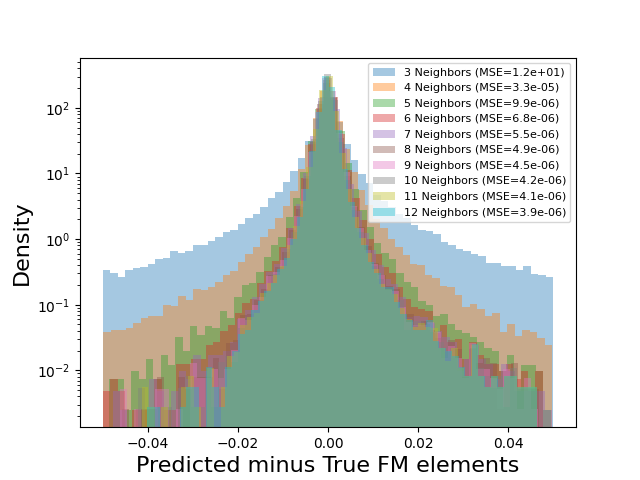

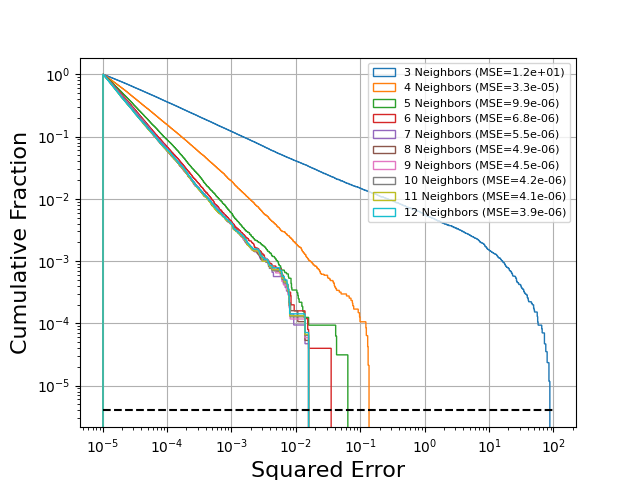

In [1299]:
nbins = 60

Gn, FMn = find_nearest_neighbors(Gc, Gs, FMs, n=n)

time_taken = {}
mse = {}
dFM = {}
Dist = {}
Plot1Dist = {}

dDist = 0.05

k = G.shape[2]
for m in range(k+1, n+1):
    time_taken[f'{m}'] = -time.time()
    FMc_pred = EstimateFM(Gc, Gn[:,:,:m,:], FMn[:,:,:,:m])
    time_taken[f'{m}'] += time.time()
    time_m = time_taken[f'{m}']
    print(f'Time {m} = {time_m:.5f} s')
    mse[f'{m}'] = MSE(FMc, FMc_pred)
    dFM[f'{m}'] = ((FMc-FMc_pred))

    Dist[f'{m}'] = dFM[f'{m}'].flatten()
    Plot1Dist[f'{m}'] = Dist[f'{m}'][np.where((Dist[f'{m}']<dDist) & (Dist[f'{m}']>-dDist))]

plt.figure(3)
plt.clf()
for m in range(k+1, n+1):
    plt.hist(Plot1Dist[f'{m}'], nbins, density=True, alpha=0.4, label='{} Neighbors (MSE={:.1e})'.format(m, mse[f'{m}']))
plt.yscale('log')
plt.xlabel('Predicted minus True FM elements', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.legend(fontsize=8)
plt.show()


dDist2 = 10

Plot2Dist = {}
for m in range(k+1, n+1):
    Plot2Dist[f'{m}'] = Dist[f'{m}'][np.where((Dist[f'{m}']<dDist2) & (Dist[f'{m}']>-dDist2))]

logmin = -5
bins = 10**(np.linspace(-5,np.log10(dDist2**2),1001)[1:])
options = {'bins':bins, 'density':True, 'cumulative':-1, 'histtype':'step', 'log':True}

plt.figure(4)
plt.clf()
for m in range(k+1, n+1):
    plt.hist(Plot2Dist[f'{m}']**2, **options, label='{} Neighbors (MSE={:.1e})'.format(m, mse[f'{m}']))
plt.hlines(1/len(Dist[f'{k+1}']), 10**logmin, dDist2**2, colors=['k'], linestyles=['dashed'])
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Squared Error', fontsize=16)
plt.ylabel('Cumulative Fraction', fontsize=16)
plt.legend(loc='upper right', fontsize=8)
plt.show()

In [1300]:
# import pandas as pd

# num_cases = 7
# dataframe = pd.DataFrame({f'{idx}':[np.nan]*num_cases for idx in range(2,n+1)}, index=['UPM','UP','UM','PM','U','P','M'])
# num_cases = 3
# dataframe = pd.DataFrame({f'{idx}':[np.nan]*num_cases for idx in range(2,n+1)}, index=['UM','U','M'])
# with open('performance.pkl', 'wb') as f:
#     f.write(pickle.dumps(dataframe))

In [1301]:
import pandas as pd

with open('performance.pkl', 'rb') as f:
    dataframe = pickle.load(f)

dataframe.loc[Case] = mse

with open('performance.pkl', 'wb') as f:
    f.write(pickle.dumps(dataframe))

In [1302]:
print()
print('Performance:')
print(' '*40, 'MSE')
print(dataframe.T)


Performance:
                                         MSE
           UM         U          M
2         NaN  0.002046  21.398764
3   12.303404  0.000023   0.000438
4    0.000033  0.000007   0.000104
5    0.000010  0.000005   0.000084
6    0.000007  0.000004   0.000067
7    0.000005  0.000004   0.000063
8    0.000005  0.000004   0.000061
9    0.000005  0.000004   0.000059
10   0.000004  0.000004   0.000057
11   0.000004  0.000003   0.000056
12   0.000004  0.000003   0.000055


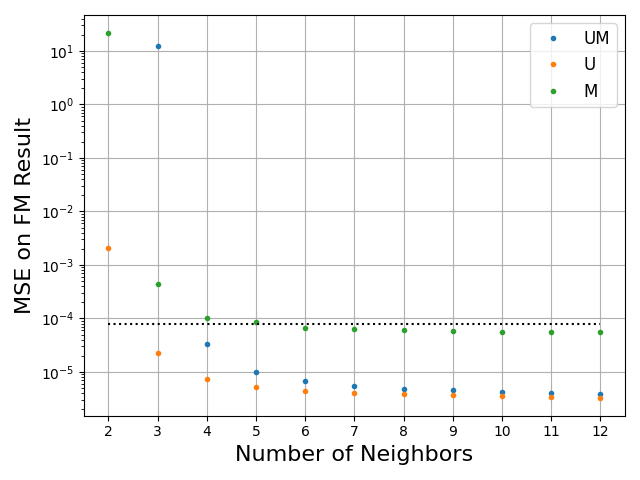

In [1303]:
plt.figure(101)
plt.clf()
plt.plot(dataframe.T, linestyle='', marker='.')
plt.hlines(np.mean((FM[:23,:,:]-FMs)**2, axis=(0,1,2)), 0, n-2, linestyles=':', colors='k', label='Trivial Case')
plt.yscale('log')
plt.grid()
plt.xlabel('Number of Neighbors', fontsize=16)
plt.ylabel('MSE on FM Result', fontsize=16)
plt.legend(dataframe.T.columns, fontsize=12)
plt.tight_layout()
plt.show()

In [1304]:
# np.mean(np.std(FMs, axis=0)**2)
print(f'{np.mean((FM[:75,:,:]-FMs)**2, axis=(0,1,2)):.6f}')

ValueError: operands could not be broadcast together with shapes (48,100,100) (23,100,100) 